# Attribute-Mask R-CNN Predictor Demo

This demo used a pre-trained model, Attribute-Mask R-CNN, described in our paper. The model checkpoint can be download [here](https://s3.amazonaws.com/ifashionist-dataset/attributes-maskrcnn/model.zip).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import PIL.ImageFont as ImageFont
import copy
import json
import sys

from pycocotools import mask
from scipy.special import softmax

import tensorflow as tf

In [3]:
# =======================================================
saved_model_dir = 'model'  # specify the model dir here
# =======================================================

session = tf.Session(graph=tf.Graph())
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model/variables/variables


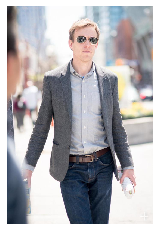

In [4]:
ontology = json.load(open('data/demo/category_attributes_descriptions'))
n_class = len(ontology['categories'])
score_th = 0.05

image_path = 'data/demo/input.jpg'
with open(image_path, 'rb') as f:
    np_image_string = np.array([f.read()])
image_raw = Image.open(image_path)
width, height = image_raw.size
image_raw = np.array(image_raw.getdata()).reshape(height, width, 3).astype(np.uint8)
plt.imshow(image_raw, interpolation='none')
plt.axis('off')

num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, detection_logits, attribute_logits, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'DetectionLogits:0', 'AttributeLogits:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})
num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
detection_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
detection_logits = np.squeeze(detection_logits, axis=(0,))[0:num_detections]
attribute_logits = np.squeeze(attribute_logits, axis=(0,))[0:num_detections]

# include attributes
attributes = []
for i in range(num_detections):
    prob = softmax(attribute_logits[i,:])
    attributes.append([j for j in range(len(prob)) if prob[j] > score_th])

pocket (95%): patch (pocket), slash (pocket), curved (pocket), flap (pocket)
buckle (98%): curved (pocket)
pocket (99%): patch (pocket), welt (pocket), slash (pocket), curved (pocket), flap (pocket)
pants (99%): maxi (length), fly (opening), no non-textile material, no special manufacturing technique, plain (pattern)
collar (99%): shirt (collar)
glasses (99%): 
lapel (99%): symmetrical, notched (lapel), single breasted
belt (99%): plain (pattern)
sleeve (99%): wrist-length, set-in sleeve
sleeve (99%): wrist-length, set-in sleeve


<Figure size 432x288 with 0 Axes>

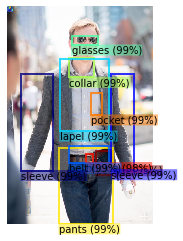

In [5]:
max_boxes_to_draw = 10

linewidth = 2
fontsize = 10
line_alpha = 0.8
mask_alpha = 0.5

output_image_path = 'results.pdf'

image = copy.deepcopy(image_raw)

cm_subsection = np.linspace(0., 1., min(max_boxes_to_draw, len(detection_scores))) 
colors = [cm.jet(x) for x in cm_subsection]

plt.figure()
fig, ax = plt.subplots(1)

for i in range(len(detection_scores)-1, -1, -1):
    if i < max_boxes_to_draw:
        # draw segmentation mask
        seg_mask = detection_masks[i,:,:]
        color = list(np.array(colors[i][:3])*255)
        pil_image = Image.fromarray(image)
        solid_color = np.expand_dims(
          np.ones_like(seg_mask), axis=2) * np.reshape(color, [1, 1, 3])
        pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert('RGBA')
        pil_mask = Image.fromarray(np.uint8(255.0*mask_alpha*seg_mask)).convert('L')
        pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
        image = np.array(pil_image.convert('RGB')).astype(np.uint8)
        
        # draw bbox
        top, left, bottom, right = detection_boxes[i,:]
        width = right - left
        height = bottom - top
        bbox = patches.Rectangle((left, top), width, height, 
                                 linewidth=linewidth, edgecolor=colors[i], 
                                 facecolor='none', alpha=line_alpha)
        ax.add_patch(bbox)

        # draw text
        attributes_str = ", ".join([ontology['attributes'][attr]['name'] for attr in attributes[i]])
        detections_str = '{} ({}%)'.format(ontology['categories'][detection_classes[i]]['name'],
                                           int(100*detection_scores[i]))
        display_str = '{}: {}'.format(detections_str, attributes_str)
        
        font = ImageFont.truetype('arial.ttf', fontsize)
        text_width, text_height = font.getsize(detections_str)
        props = dict(boxstyle='Round, pad=0.05', facecolor=colors[i], linewidth=0, alpha=mask_alpha)
        ax.text(left, bottom, detections_str, fontsize=fontsize, verticalalignment='top', bbox=props)
        print(display_str)
        
plt.imshow(image, interpolation='none')
plt.axis('off')
plt.savefig('data/demo/result.pdf', transparent=True, bbox_inches='tight', pad_inches=0.05)

### Note

The Fashionpedia does not own the copyright of the images. The users of the Fashionpedia accept full responsibility for the use of the Fashionpedia dataset, including but not limited to the use of any copies of copyrighted images that they may create from the Fashionpedia.
Check out our [Terms of Use](https://fashionpedia.github.io/home/data_license.html) for more details.